## Solution to the third project

#### All the imports here

In [2]:
import numpy as np
import numpy.linalg as la
import random
import sys
import time
from scipy.cluster.vq import kmeans2, kmeans

#### Making matplotlib more tolerable

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
%pylab inline
plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Task 3.1 (Marek)

In [4]:
def calcDistance(center, point):
    return np.sqrt(np.power(center[0] - point[0], 2) + np.power(center[1] - point[1], 2))


def assignPointsToNearestCluster(centers, data):
    # create index array to tag cluster to each data point
    index = np.zeros(len(data[0, :]))
    # assign points to clusters/centers
    for i in range(len(data[0, :])):
        min_dist = sys.float_info.max
        cluster = -1
        for j in range(len(centers[:, 0])):
            distFromCenterToPoint = calcDistance(centers[j, :], data[:, i])
            if distFromCenterToPoint < min_dist:
                min_dist = distFromCenterToPoint
                cluster = j

        index[i] = cluster

        # SOME POSSIBILITY TO SPEED UP
        # tree = scipy.spatial.KDTree( centers )
        # index = np.zeros( len(data[0,:]) )

        # # assign points to clusters/centers
        # for i in range( len(data[0,:]) ):
        # [ distance , location] = tree.query( data[:,i] )
        # index[i] = location
        # return index

    return index


def calculateObjectiveFunction(centers, data, index, j, i, original_size, new_center0, new_center1):
    #error = 0.0
    #for i in range(len(data[0, :])):
    #    for j in range(len(centers[:, 0])):
    #        if index[i] == j:
    #            error += calcDistance(centers[j, :], data[:, i])
    new_center = [new_center0, new_center1]
    return calcDistance(new_center, data[:, i]) + original_size * calcDistance(centers[j, :], new_center)



def calcMeanOfCenter(centers, index, i):
    centers[i, 0] = 0.0
    centers[i, 1] = 0.0

    # calculate new position of centroid i
    num_of_points_in_cluster = sum(index == i)  # sum number of points assigned to a center

    for j in range(len(index)):  # loop over all indexes of points
        if index[j] == i:  # if point is assigned to center add it
            centers[i, 0] = centers[i, 0] + data[0, j]
            centers[i, 1] = centers[i, 1] + data[1, j]

    if num_of_points_in_cluster != 0:
        centers[i, 0] /= float(num_of_points_in_cluster)
        centers[i, 1] /= float(num_of_points_in_cluster)

    return centers


def determineWinnerCentroid(centers, x):
    min_dist = sys.float_info.max
    center_index = -1
    for i in range(len(centers[:, 0])):
        distFromCenterToPoint = calcDistance(centers[i, :], x)
        if (distFromCenterToPoint < min_dist):
            min_dist = distFromCenterToPoint
            center_index = i

    return center_index


def LIoyds_Built_in(data, k):

    data_transposed = np.transpose(data)
    centers , distortion_factor = kmeans( data_transposed , k)
    index = assignPointsToNearestCluster(centers, data)

    return index, centers

def LIoyds(data, k):
    min_val_X, min_val_Y, max_val_X, max_val_Y = min(data[0, :]), min(data[1, :]), max(data[0, :]), max(data[1, :])

    # initialize centers
    centers = np.zeros((k, 2), np.float64)
    for i in range(k):
        centers[i, 0] = random.uniform(min_val_X, max_val_X)
        centers[i, 1] = random.uniform(min_val_Y, max_val_Y)

    index = np.zeros(len(data[0, :]))
    index_previous = np.zeros(len(data[0, :]))

    # loop until there is no change in assignment to clusters
    count = 0
    while True:
        count+=1
        index = assignPointsToNearestCluster(centers, data)

        # if assignment to centers did not change then stop algorithm
        if np.array_equal(index, index_previous):
            break

        # compute centers for all centroids
        for l in range(k):
            centers = calcMeanOfCenter(centers, index, l)

        index_previous = np.copy(index)
    #print count
    return index, centers


def Hartigan(data, k):
    # initialize centers
    centers = np.zeros((k, 2), np.float64)
    n = len(data[0, :])

    # randomly assign points to clusters
    index = np.zeros(n)
    for i in range(n):
        index[i] = random.randint(0, k-1)

    # compute mean of centers, we only need to compute before iteration once
    for i in range(0, k):
        centers = calcMeanOfCenter(centers, index, i)

    converged = False
    # loop until there is no change in assignment to clusters
    count = 0
    while converged is False:
        count+=1
        converged = True
        for j in range(n):
            init_center = index[j]  # get center i of point j
            original_size = sum(index == init_center)
            index[j] = -1  # remove point j from center
            centers[init_center, 0] = (centers[init_center, 0] * original_size - data[0, j]) / (original_size-1)
            centers[init_center, 1] = (centers[init_center, 1] * original_size - data[1, j]) / (original_size-1)
            min_error = sys.float_info.max
            proper_cluster = -1

            for i in range(k):
                original_size = sum(index == i)
                index[j] = i  # assign point j to cluster i
                new_center0 = (centers[i, 0] * original_size + data[0, j]) / (original_size+1)
                new_center1 = (centers[i, 1] * original_size + data[1, j]) / (original_size+1)
                objFunResult = calculateObjectiveFunction(centers, data, index, i, j, original_size, new_center0, new_center1)
                if min_error > objFunResult:
                    min_error = objFunResult
                    proper_cluster = i

            if proper_cluster != init_center:  # if no change in assignment to centers
                converged = False  # converged

            size = sum(index == proper_cluster)
            index[j] = proper_cluster  # assign point to cluster for which objective function is the lowest
            centers[proper_cluster, 0] = (centers[proper_cluster, 0] * size + data[0, j]) / (size+1)
            centers[proper_cluster, 1] = (centers[proper_cluster, 1] * size + data[1, j]) / (size+1)
    #print count
    return index, centers

def MacQueen(data , k):
    min_val_X = min(data[0, :])
    min_val_Y = min(data[1, :])
    max_val_X = max(data[0, :])
    max_val_Y = max(data[1, :])

    # initialize centers
    centers = np.zeros((k, 2), np.float64 )
    for i in range(k):
        centers[i, 0] = random.uniform(min_val_X, max_val_X)
        centers[i, 1] = random.uniform(min_val_Y, max_val_Y)

    n = 0
    for j in range(len(data[0, :])):
        center_index = determineWinnerCentroid(centers, data[:, j])
        n += 1
        centers[center_index, :] += 1/float(n)*(data[:, j] - centers[center_index, :])

    index = assignPointsToNearestCluster(centers, data)

    return index, centers


def plotData(data , indexes , centers , k,  str, axs):
    colors = ['red', 'orange', 'green']
    for i in range(0, k):
        bool_idx = (indexes == i)
        axs.scatter(data[0, bool_idx], data[1, bool_idx], color=colors[i])
        axs.scatter(centers[i, 0], centers[i, 1], s=100, color=colors[i], edgecolors='black')

    axs.set_title(str)
    return axs

def box_plot_with_special_point(equal_list, equal_special_list, str_):
    """
    box plot with single models, as well as Tverberg point, Average point, All point
    """
    fig1 = plt.figure(1, figsize=(8, 8))
    ax = fig1.add_subplot(111)
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

    # get all the variance value w.r.t equal_list(random_list)

    randomDists = ['LIoyds buildin: ' + str(round(np.var(equal_list[0]), 5)), 'LIoyds: '+str(round(np.var(equal_list[1]), 5)), 'Hartigan: ' + str(round(np.var(equal_list[2
         ]), 5)), 'MacQueen: '+str(round(np.var(equal_list[3]), 5))]

    bp_0 = ax.boxplot(equal_list, 1, meanprops=meanlineprops, meanline=True, showmeans=True)

    # Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    # Hide these grid behind plot objects
    ax.set_axisbelow(True)

    # add xtick name with variance value
    xticksNames = plt.setp(ax, xticklabels=np.repeat(randomDists, 1))
    plt.setp(xticksNames, fontsize=10)

    # change outline color, fill color and linewidth of the boxes
    for box in bp_0['boxes']:
        # change outline color
        box.set(color='#7570b3', linewidth=1)

    # change color and linewidth of the whiskers
    for whisker in bp_0['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    # change color and linewidth of the caps
    for cap in bp_0['caps']:
        cap.set(color='#7570b3', linewidth=2)

    # change color and linewidth of the medians
    for i, median in enumerate(bp_0['medians']):
        if i == 0:
            median.set(color='#b2df8a', linewidth=2, label="median")
        else:
            median.set(color='#b2df8a', linewidth=2)
    
    dash_line = mlines.Line2D([], [], color='purple', label='mean', linestyle='--')
    median_line = mlines.Line2D([], [], color='#b2df8a', label='median', linestyle='-')
    ax.set_xlabel('clustering algorithms, 30 runs each, variance')
    ax.set_ylabel('run time(s)')
    # Put a legend below current axis
    f1 = plt.legend(handles=[dash_line, median_line], loc=1, prop={'size':10})

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax = plt.gca().add_artist(f1)

def measureAlgRunTimes(data):
    time_lioyds_built = []
    for i in range(30):
        start = time.time()
        LIoyds_Built_in(data, 3)
        end = time.time()
        time_lioyds_built.append(end - start)
    print "LIoyds algorithm built-in time:   ", np.mean(np.array(time_lioyds_built))

    time_lioyds = []
    for i in range(30):
        start = time.time()
        LIoyds(data, 3)
        end = time.time()
        time_lioyds.append(end - start)
    print "LIoyds algorithm average time:   ", np.mean(np.array(time_lioyds))

    
    time_hartigan = []
    for i in range(30):
        start = time.time()
        Hartigan(data, 3)
        end = time.time()
        time_hartigan.append(end - start)
    print "Hartigan algorithm average time:   ", np.mean(np.array(time_hartigan))

    time_macqueen = []
    for i in range(30):
        start = time.time()
        MacQueen(data, 3)
        end = time.time()
        time_macqueen.append(end - start)
    print "MacQueen algorithm average time:   ", np.mean(np.array(time_macqueen))
    
    time_all = [time_lioyds_built, time_lioyds, time_hartigan, time_macqueen]
    box_plot_with_special_point(time_all, '', '')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:138: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:139: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Humor Sans', u'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


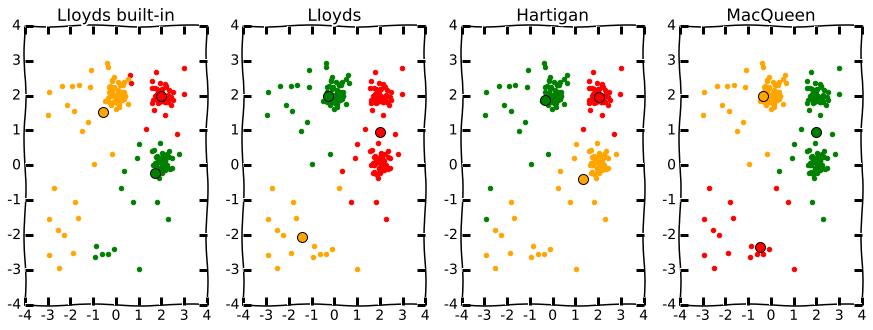

LIoyds algorithm built-in time:    0.0174100557963
LIoyds algorithm average time:    0.0473472992579
Hartigan algorithm average time:    0.148664752642
MacQueen algorithm average time:    0.0180681864421


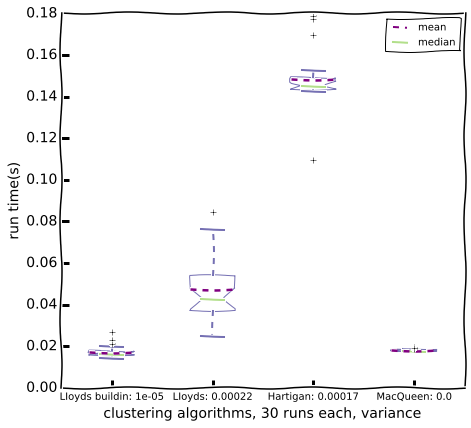

In [5]:
data = np.loadtxt('resources/data-clustering-1.csv', None, comments='#', delimiter=',')
fig = plt.figure(figsize=(15,5))
axs1 = fig.add_subplot(141)
axs2 = fig.add_subplot(142)
axs3 = fig.add_subplot(143)
axs4 = fig.add_subplot(144)

[indexes, centers] = LIoyds_Built_in(data, 3)
axs1 = plotData(data, indexes, centers, 3, "LIoyds built-in", axs1)

[indexes, centers] = LIoyds(data, 3)
axs2 = plotData(data, indexes, centers, 3, "LIoyds", axs2)

[indexes, centers] = Hartigan(data, 3)
axs3 = plotData(data, indexes, centers, 3, "Hartigan", axs3)

[indexes, centers] = MacQueen(data, 3)
axs4 = plotData(data, indexes, centers, 3, "MacQueen", axs4)


plt.show()
measureAlgRunTimes(data)

In [6]:
def spectral(beta, data, axs):
    n = len(data[0])
    S = np.zeros((n,n))
    D = np.zeros((n,n))
    
    # spectral clustering
    for i in range(n):
        for j in range(n):
            xi = data[:,i]
            xj = data[:,j]
            S[i][j] = np.exp(-beta*(np.power(np.linalg.norm(xi-xj), 2)))
        D[i][i] = np.sum(S[i])

    L = np.zeros((n,n))
    L = D - S

    # compute eigen values and eigen vectors, ascending order
    eigval, eigvec = la.eigh(L)

    #To cluster the given data into two clusters C1 and C2, do the following: 
    #If entry i of u2 is greater than 0 assign xi to cluster C1, 
    #it it is less than zero, assign xi to cluster C2.
    cluster1 = [[],[]]
    cluster2 = [[],[]]
    for i in range(n):
        if eigvec[:, 1][i] > 0:
            cluster1[0].append(data[0][i])
            cluster1[1].append(data[1][i])
        else:
            cluster2[0].append(data[0][i])
            cluster2[1].append(data[1][i])

    axs.scatter(cluster1[0],cluster1[1], color='r')
    axs.scatter(cluster2[0],cluster2[1], color='g')
    axs.set_title('Spectral beta='+str(beta))

### Task 3.2 (Yobibyte)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:138: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:139: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


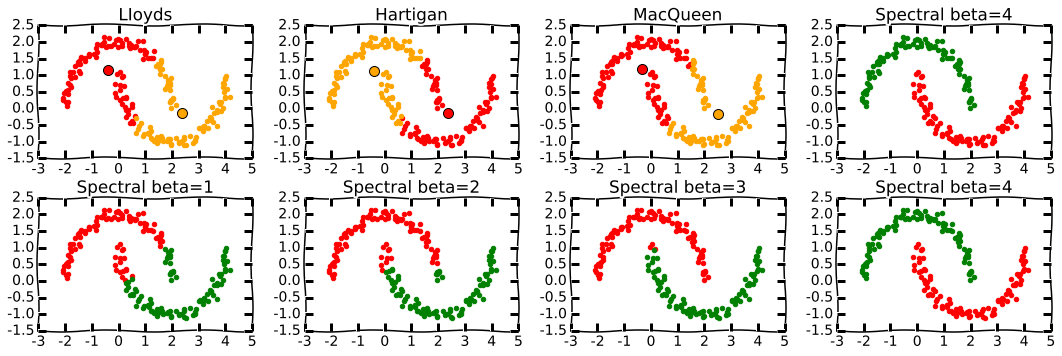

In [7]:
data = np.loadtxt('resources/data-clustering-2.csv', None, comments='#', delimiter=',')

def spectralClustering( beta ):
    k = 2
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
    fig.tight_layout()
    # use lloyds here
    [indexes, centers] = LIoyds(data , k)
    axs[0][0] = plotData(data,indexes,centers, k, "LIoyds" , axs[0][0])
    # use Hartigan here
    [indexes, centers] = Hartigan(data , k)
    axs[0][1] = plotData(data,indexes,centers, k, "Hartigan", axs[0][1])
    # use MacQueen here
    [indexes, centers] = MacQueen(data , k)
    axs[0][2] = plotData(data,indexes,centers, k, "MacQueen", axs[0][2])
    # use spectral
    spectral(beta, data, axs[0][3])

    for i in range(beta):
        spectral(i+1, data, axs[1][i])
    
spectralClustering( 4 )

plt.show()

### Task 3.3 (Yakun)

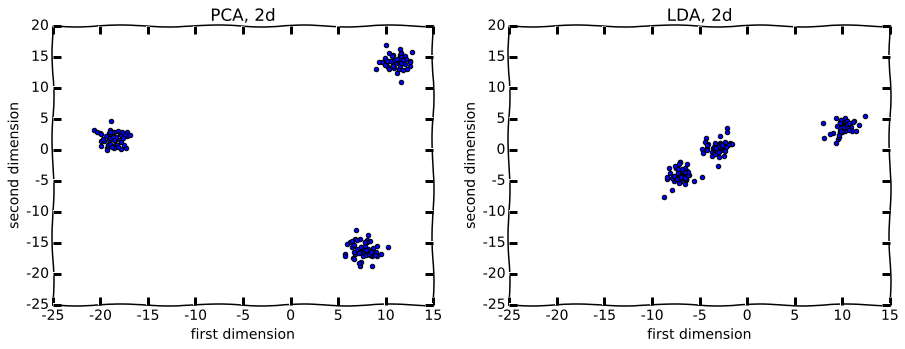

In [17]:
dataX = np.loadtxt('resources/data-dimred-X.csv', None, comments='#', delimiter=',')
dataY = np.loadtxt('resources/data-dimred-y.csv', None, comments='#', delimiter=',')
num_row, num_col = np.shape(dataX)

# add all columns and divide the number of columns
x_mean = dataX.sum(axis=1, dtype='float') / num_col 

# substract all columns by x_mean to move data set to 0 mean, get X tranpose here
Xtr = np.transpose(dataX) - x_mean

# data covariance matrix
X = np.transpose(Xtr)
C = np.dot(X, Xtr) / num_col

# compute eigen values and eigen vectors
evalsh, evectsh = la.eigh(C)

# sort eigen values and eigen vectors in descending order
indx = np.argsort(evalsh)[::-1]
evalsh = evalsh[indx]
evectsh = evectsh[:, indx]

# use largest two eigen vector to project the data into 2d
X2d = np.dot(np.transpose(evectsh[:, [0, 1]]), X)

## below is the implementation of LDA

# get index for 1, 2, 3 from Y
ind = np.vstack((np.vstack((np.where(dataY == 1)[0], np.where(dataY == 2)[0])), np.where(dataY == 3)[0]))

# get the mean of each class
mean_one = X[:, ind[0]].sum(axis=1, dtype='float') / len(ind[0])
mean_two = X[:, ind[1]].sum(axis=1, dtype='float') / len(ind[1])
mean_thr = X[:, ind[2]].sum(axis=1, dtype='float') / len(ind[2])

# get each data class substract the corresponding mean
sub_mat_one = X[:, ind[0]] - np.vstack(mean_one)
sub_mat_two = X[:, ind[1]] - np.vstack(mean_two)
sub_mat_thr = X[:, ind[2]] - np.vstack(mean_thr)

# compute within class scatter matrix
Sw = np.dot(sub_mat_one, np.transpose(sub_mat_one)) + np.dot(sub_mat_two, np.transpose(sub_mat_two)) + np.dot(sub_mat_thr, np.transpose(sub_mat_thr))

# compute the between class scatter matrix 
mean_all = (len(ind[0]) * mean_one + len(ind[1]) * mean_two + len(ind[2]) * mean_thr) / 150
sub_mean_123 = mean_one - mean_all
sub_mean_213 = mean_two - mean_all
sub_mean_312 = mean_thr - mean_all
Sb = np.vstack(sub_mean_123) * sub_mean_123 + np.vstack(sub_mean_213) * sub_mean_213 + np.vstack(sub_mean_312) * sub_mean_312

# compute eigen values and eigen vectors
evalsh_lda, evectsh_lda = la.eigh(np.dot(np.linalg.inv(Sw), Sb))

# sort eigen values and eigen vectors in descending order
indx_lda = np.argsort(evalsh_lda)[::-1]
evalsh_lda = evalsh_lda[indx_lda]
evectsh_lda = evectsh_lda[:, indx_lda]

# use largest two eigen vector to project the data into 2d
X2d_lda = np.dot(np.transpose(evectsh_lda[:, [0, 1]]), X)

# get 3d dataset
X3d = np.dot(np.transpose(evectsh[:, [0, 1, 2]]), X)
X3d_lda = np.dot(np.transpose(evectsh_lda[:, [0, 1, 2]]), X)

# plot
#fig, axes = plt.subplots(ncols=2, figsize=(15,5))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#ax = fig.add_subplot(1, 2, 1, projection='3d')


ax[0].set_title('PCA, 2d')
ax[1].set_title('LDA, 2d')
for i in range(2):
    ax[i].set_xlabel('first dimension')
    ax[i].set_ylabel('second dimension')
    ax[i].set_xlim([-25.0,15.0])
    ax[i].set_ylim([-25.0,20.0])
    legend = ax[i].legend(loc='upper left', prop={'size':9})
    if i is 0:
        ax[i].scatter(X2d[0], X2d[1])
    else:
        ax[i].scatter(X2d_lda[0], X2d_lda[1])

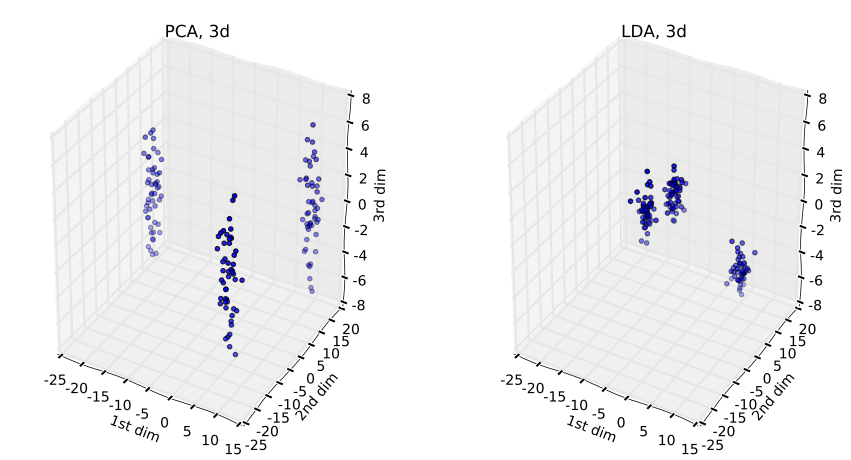

In [18]:
fig2 = plt.figure(figsize=(15, 8)) 

ax1 = fig2.add_subplot(1, 2, 1, projection='3d')
ax2 = fig2.add_subplot(1, 2, 2, projection='3d')
ax1.set_title('PCA, 3d')
ax2.set_title('LDA, 3d')
ax = [ax1, ax2]
for i in range(2):
    ax[i].set_xlabel('1st dim')
    ax[i].set_ylabel('2nd dim')
    ax[i].set_zlabel('3rd dim')
    ax[i].set_xlim([-25.0,15.0])
    ax[i].set_ylim([-25.0,20.0])
    ax[i].set_zlim([-8.0,8.0])
    if i is 0:
        ax[i].scatter(X3d[0], X3d[1], X3d[2], label='3d data')
    else:
        ax[i].scatter(X3d_lda[0], X3d_lda[1], X3d_lda[2], label='3d data')

In [15]:
def plot_data_and_fit(h, w, x, y, axs, title):
    axs.set_title(title)
    axs.plot(h, w, 'ko', x, y, 'r-')
    axs.set_xlim(xmin,xmax)
    axs.set_ylim(ymin,ymax)

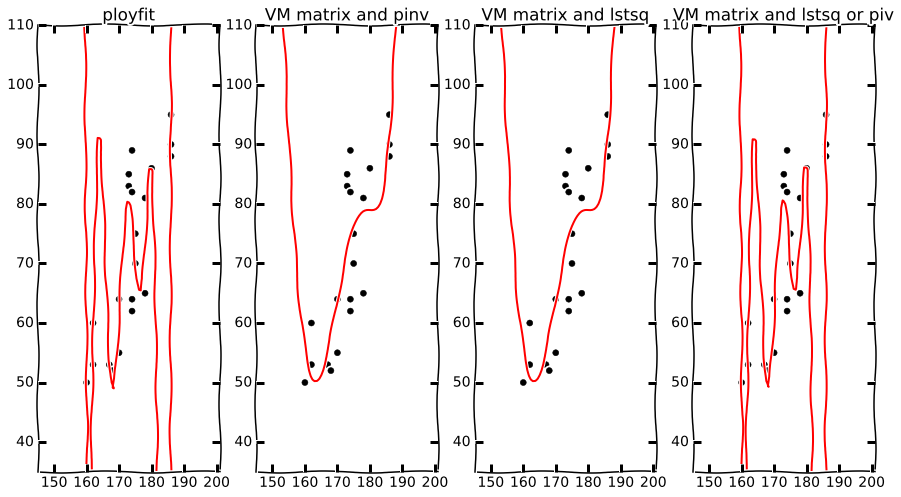

In [17]:
import numpy as np
import numpy.linalg as la
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt


dt = np.dtype([('w', np.float), ('h', np.float), ('g', 'S1')])
data = np.loadtxt('resources/whData.dat', dtype=dt, comments='#', delimiter=None)

wgt = data['w']
hgt = data['h']

# remove the outliers and collect the re-maining height and weight data into hgt and wgt
hgt = np.delete(hgt, np.where(wgt < 0), None)
wgt = np.delete(wgt, np.where(wgt < 0), None)

xmin = hgt.min()-15
xmax = hgt.max()+15
ymin = wgt.min()-15
ymax = wgt.max()+15

fig = plt.figure(figsize=(15, 8))
axs1 = fig.add_subplot(141)
axs2 = fig.add_subplot(142)
axs3 = fig.add_subplot(143)
axs4 = fig.add_subplot(144)


def trsf(x):
    return x / 100.

n = 10
x = np.linspace(xmin, xmax, 100)

# method 1:
# regression using ployfit
c = poly.polyfit(hgt, wgt, n)
y = poly.polyval(x, c)
plot_data_and_fit(hgt, wgt, x, y, axs1, "ployfit")


# method 2:
# regression using the Vandermonde matrix and pinv
X = poly.polyvander(hgt, n)
c = np.dot(la.pinv(X), wgt)
y = np.dot(poly.polyvander(x,n), c)
plot_data_and_fit(hgt, wgt, x, y, axs2, "VM matrix and pinv")

# method 3:
# regression using the Vandermonde matrix and lstsq

X = poly.polyvander(hgt, n)
c = la.lstsq(X, wgt)[0]
y = np.dot(poly.polyvander(x,n), c)
plot_data_and_fit(hgt, wgt, x, y, axs3, "VM matrix and lstsq")


# method 4:
# regression on transformed data using the Vandermonde
# matrix and either pinv or lstsq
X = poly.polyvander(trsf(hgt), n)
c = np.dot(la.pinv(X), wgt)
y = np.dot(poly.polyvander(trsf(x),n), c)
plot_data_and_fit(hgt, wgt, x, y, axs4, "VM matrix and lstsq or piv")